# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Importing Libraries

In [67]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Working on Portfolio Dataset

In [68]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [69]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [70]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [71]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [72]:
portfolio.shape

(10, 6)

In [73]:
#creating a copy of the datast to work on it
copy_portfolio = portfolio.copy()

In [74]:
copy_portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [75]:
# channel dummies
mlb = MultiLabelBinarizer()
channel_dummies = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_, index=portfolio.index)

# offer type dummies
offer_type_dummies = portfolio['offer_type'].str.get_dummies()

copy_portfolio = pd.concat([portfolio, channel_dummies, offer_type_dummies], axis=1)
copy_portfolio.rename(columns={'id':'offer_id'}, inplace = True)



In [76]:
copy_portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0


In [77]:
# drop the columns channels and offer_type 
copy_portfolio.drop(['channels'], axis = 1, inplace = True)

In [78]:
# converting offer type to numerical form
labels_offer_type = copy_portfolio['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}

In [79]:
copy_portfolio.replace(replace_map_comp_offer_type, inplace=True)

In [80]:
copy_portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,3,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,2,5,1,0,0,1,0,1,0


## Working on Profile Dataset

In [81]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [82]:
copy_profile = profile.copy()

In [83]:
copy_profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [84]:
d = copy_profile.loc[copy_profile['age'] == 118]

In [85]:
d.shape

(2175, 5)

In [86]:
d.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [87]:
copy_profile['age'].min()

18

In [88]:
copy_profile = copy_profile[copy_profile.age != 118]

Removing all the rows where age = 118 as all of the values with that age were NaN.

In [89]:
copy_profile.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [90]:
copy_profile.isnull().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [91]:
copy_profile['became_member_on'] = pd.to_datetime(copy_profile['became_member_on'], format='%Y%m%d')

# gender type dummies
copy_profile['year_joined'] = copy_profile['became_member_on'].apply(lambda x: str(x.year))
copy_profile['became_member_tenure'] = (datetime.today().date() - pd.to_datetime(copy_profile['became_member_on'],format='%Y%m%d').dt.date).dt.days

gender_dummies = copy_profile['gender'].str.get_dummies().add_prefix('gender_')
year_joined_dummies = copy_profile['year_joined'].str.get_dummies().add_prefix('year_joined_')

copy_profile = pd.concat([copy_profile, gender_dummies, year_joined_dummies], axis=1)

copy_profile.rename(columns = {'id' : 'customer_id'}, inplace = True)

In [92]:
copy_profile.head()

,age,became_member_on,gender,customer_id,income,year_joined,became_member_tenure,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,1114,1,0,0,0,0,0,0,1,0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,1181,1,0,0,0,0,0,0,1,0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,829,0,1,0,0,0,0,0,0,1
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,905,0,1,0,0,0,0,0,0,1
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,995,0,1,0,0,0,0,0,1,0


In [93]:
copy_profile.drop(['became_member_on'], axis=1, inplace=True)
copy_profile.drop(['year_joined'], axis=1, inplace=True)

Dropped became_member_on and year_joined as it were of no use to me

In [94]:
copy_profile.head()

,age,gender,customer_id,income,became_member_tenure,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1114,1,0,0,0,0,0,0,1,0
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1181,1,0,0,0,0,0,0,1,0
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,829,0,1,0,0,0,0,0,0,1
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,905,0,1,0,0,0,0,0,0,1
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,995,0,1,0,0,0,0,0,1,0


## Working on Transcript Dataset

In [95]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [96]:
copy_transcript = transcript.copy()

In [97]:
copy_transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [98]:
event_dummies = copy_transcript['event'].str.get_dummies()
event_dummies.drop('transaction', axis=1, inplace=True)

copy_transcript = pd.concat([transcript, event_dummies], axis=1)
copy_transcript.rename(columns={'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace=True)

# converting offer type to numerical form
labels_event = copy_transcript['event'].astype('category').cat.categories.tolist()
replace_map_comp_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}

In [135]:
replace_map_comp_event

{'event': {'offer completed': 1,
  'offer received': 2,
  'offer viewed': 3,
  'transaction': 4}}

In [99]:
copy_transcript.replace(replace_map_comp_event, inplace=True)

In [100]:
profile_118 = profile[profile['age'] == 118]

In [101]:
id_age_118 = profile_118['id'].unique().tolist()
transcript['person'].isin(id_age_118).value_counts()

False    272762
True      33772
Name: person, dtype: int64

In [102]:
copy_transcript.rename(columns={'person': 'customer_id'}, inplace=True)
    
# Remove observations having customers with age 118 from transcript dataframe
copy_transcript = copy_transcript[~copy_transcript['customer_id'].isin(id_age_118)]

In [103]:
copy_transcript.head()

,event,customer_id,time,value,offer_completed,offer_received,offer_viewed
0,2,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0
2,2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0
5,2,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,1,0
7,2,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,1,0
8,2,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0


In [104]:
# Extract each key that exist in 'value' column to a seperate column.
# getting the different keys  that exists in the 'value' column
keys = []
for idx, row in copy_transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)

In [105]:
keys

['offer id', 'amount', 'offer_id', 'reward']

In [106]:
copy_transcript['offer_id'] = '' # datatype : string
copy_transcript['amount'] = 0  # datatype : integer
copy_transcript['reward'] = 0  # datatype : integer

In [107]:
# Iterating over clean_transcript dataset and checking 'value' column
# then updating it and using the values to fill in the columns created above
for idx, row in copy_transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id': # b/c 'offer_id' and 'offer id' are representing the same thing 
            copy_transcript.at[idx, 'offer_id'] = row['value'][k]
        if k == 'amount':
            copy_transcript.at[idx, 'amount'] = row['value'][k]
        if k == 'reward':
            copy_transcript.at[idx, 'reward'] = row['value'][k]

In [108]:
copy_transcript['offer_id'] = copy_transcript['offer_id'].apply(lambda x: 'N/A' if x == '' else x)

In [109]:
copy_transcript.drop('value', axis=1, inplace=True)

In [110]:
copy_transcript.head()

,event,customer_id,time,offer_completed,offer_received,offer_viewed,offer_id,amount,reward
0,2,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
2,2,e2127556f4f64592b11af22de27a7932,0,0,1,0,2906b810c7d4411798c6938adc9daaa5,0,0
5,2,389bc3fa690240e798340f5a15918d5c,0,0,1,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0
7,2,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,3f207df678b143eea3cee63160fa8bed,0,0
8,2,aa4862eba776480b8bb9c68455b8c2e1,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0


## Merging all the Datasets into one

In [111]:
df = pd.merge(copy_transcript, copy_portfolio, on = 'offer_id')

In [112]:
df = pd.merge(df, copy_profile, on = 'customer_id')

## Exploring the Merged Dataset

In [113]:
df.head()

,event,customer_id,time,offer_completed,offer_received,offer_viewed,offer_id,amount,reward_x,difficulty,...,became_member_tenure,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,2,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5,...,1181,1,0,0,0,0,0,0,1,0
1,3,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5,...,1181,1,0,0,0,0,0,0,1,0
2,1,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,5,...,1181,1,0,0,0,0,0,0,1,0
3,2,78afa995795e4d85b5d9ceeca43f5fef,504,0,1,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0,5,...,1181,1,0,0,0,0,0,0,1,0
4,1,78afa995795e4d85b5d9ceeca43f5fef,510,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,...,1181,1,0,0,0,0,0,0,1,0


In [114]:
pd.set_option('display.max_columns', None)

In [115]:
df.shape

(148805, 33)

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 33 columns):
event                   148805 non-null int64
customer_id             148805 non-null object
time                    148805 non-null int64
offer_completed         148805 non-null int64
offer_received          148805 non-null int64
offer_viewed            148805 non-null int64
offer_id                148805 non-null object
amount                  148805 non-null int64
reward_x                148805 non-null int64
difficulty              148805 non-null int64
duration                148805 non-null int64
offer_type              148805 non-null int64
reward_y                148805 non-null int64
email                   148805 non-null int64
mobile                  148805 non-null int64
social                  148805 non-null int64
web                     148805 non-null int64
bogo                    148805 non-null int64
discount                148805 non-null int64
informational

In [117]:
df.isnull().sum()

event                   0
customer_id             0
time                    0
offer_completed         0
offer_received          0
offer_viewed            0
offer_id                0
amount                  0
reward_x                0
difficulty              0
duration                0
offer_type              0
reward_y                0
email                   0
mobile                  0
social                  0
web                     0
bogo                    0
discount                0
informational           0
age                     0
gender                  0
income                  0
became_member_tenure    0
gender_F                0
gender_M                0
gender_O                0
year_joined_2013        0
year_joined_2014        0
year_joined_2015        0
year_joined_2016        0
year_joined_2017        0
year_joined_2018        0
dtype: int64

In [118]:
df.head()

,event,customer_id,time,offer_completed,offer_received,offer_viewed,offer_id,amount,reward_x,difficulty,duration,offer_type,reward_y,email,mobile,social,web,bogo,discount,informational,age,gender,income,became_member_tenure,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,2,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5,7,1,5,1,1,0,1,1,0,0,75,F,100000.0,1181,1,0,0,0,0,0,0,1,0
1,3,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5,7,1,5,1,1,0,1,1,0,0,75,F,100000.0,1181,1,0,0,0,0,0,0,1,0
2,1,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,5,7,1,5,1,1,0,1,1,0,0,75,F,100000.0,1181,1,0,0,0,0,0,0,1,0
3,2,78afa995795e4d85b5d9ceeca43f5fef,504,0,1,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0,5,5,1,5,1,1,1,1,1,0,0,75,F,100000.0,1181,1,0,0,0,0,0,0,1,0
4,1,78afa995795e4d85b5d9ceeca43f5fef,510,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,5,1,5,1,1,1,1,1,0,0,75,F,100000.0,1181,1,0,0,0,0,0,0,1,0


In [119]:
df['age'].min()

18

In [120]:
df['age'].unique()

array([ 75,  59,  40,  45,  54,  79,  73,  53,  72,  18,  55,  52,  69,
        62,  90,  34,  68,  60,  50,  48,  70,  63,  43,  76,  67,  51,
        66,  65,  61,  41,  78,  47,  84,  33,  37,  49,  39,  57,  46,
        74,  25,  38,  58,  20,  56,  64,  80,  77,  19,  23,  32,  35,
        31,  22,  36,  71,  24,  83,  44,  86,  26,  82,  30,  29,  21,
        87,  81,  94,  28,  97,  42,  27,  92,  88,  85,  91,  95,  96,
        89, 100,  99, 101,  93,  98])

In [121]:
df['age_bins'] = pd.cut(x=df['age'], bins=[10, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109])

In [122]:
df.head()

,event,customer_id,time,offer_completed,offer_received,offer_viewed,offer_id,amount,reward_x,difficulty,duration,offer_type,reward_y,email,mobile,social,web,bogo,discount,informational,age,gender,income,became_member_tenure,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,age_bins
0,2,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5,7,1,5,1,1,0,1,1,0,0,75,F,100000.0,1181,1,0,0,0,0,0,0,1,0,"(69, 79]"
1,3,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5,7,1,5,1,1,0,1,1,0,0,75,F,100000.0,1181,1,0,0,0,0,0,0,1,0,"(69, 79]"
2,1,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,5,7,1,5,1,1,0,1,1,0,0,75,F,100000.0,1181,1,0,0,0,0,0,0,1,0,"(69, 79]"
3,2,78afa995795e4d85b5d9ceeca43f5fef,504,0,1,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0,5,5,1,5,1,1,1,1,1,0,0,75,F,100000.0,1181,1,0,0,0,0,0,0,1,0,"(69, 79]"
4,1,78afa995795e4d85b5d9ceeca43f5fef,510,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,5,1,5,1,1,1,1,1,0,0,75,F,100000.0,1181,1,0,0,0,0,0,0,1,0,"(69, 79]"


In [123]:
df['age_bins'].unique()

[(69, 79], (49, 59], (39, 49], (10, 19], (59, 69], (89, 99], (29, 39], (79, 89], (19, 29], (99, 109]]
Categories (10, interval[int64]): [(10, 19] < (19, 29] < (29, 39] < (39, 49] ... (69, 79] < (79, 89] < (89, 99] < (99, 109]]

In [124]:
df['age_by_decade'] = pd.cut(x=df['age'], bins=[10,19, 29, 39, 49, 59, 69, 79, 89, 99, 109], 
                             labels=['Late Teens', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '110s'])

In [125]:
df['age_by_decade'].unique()

[70s, 50s, 40s, Late Teens, 60s, 90s, 30s, 80s, 20s, 110s]
Categories (10, object): [Late Teens < 20s < 30s < 40s ... 70s < 80s < 90s < 110s]

In [126]:
df.isnull().sum()

event                   0
customer_id             0
time                    0
offer_completed         0
offer_received          0
offer_viewed            0
offer_id                0
amount                  0
reward_x                0
difficulty              0
duration                0
offer_type              0
reward_y                0
email                   0
mobile                  0
social                  0
web                     0
bogo                    0
discount                0
informational           0
age                     0
gender                  0
income                  0
became_member_tenure    0
gender_F                0
gender_M                0
gender_O                0
year_joined_2013        0
year_joined_2014        0
year_joined_2015        0
year_joined_2016        0
year_joined_2017        0
year_joined_2018        0
age_bins                0
age_by_decade           0
dtype: int64

In [127]:
df.columns[df.isnull().any()]

Index([], dtype='object')

## Visualization

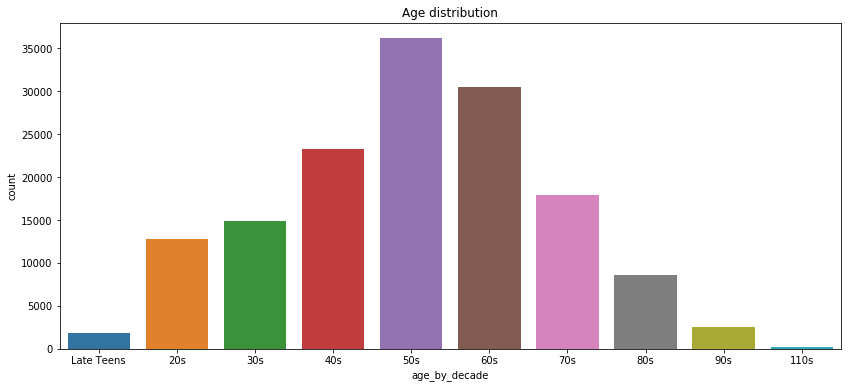

In [128]:
# Finding out the age distribution of the App Users
plt.figure(figsize=(14, 6))
ax = sns.countplot(x='age_by_decade', data=df)
ax.set_title('Age distribution');

Looks like the ones on their 50s are more likely to visit a Starbucks

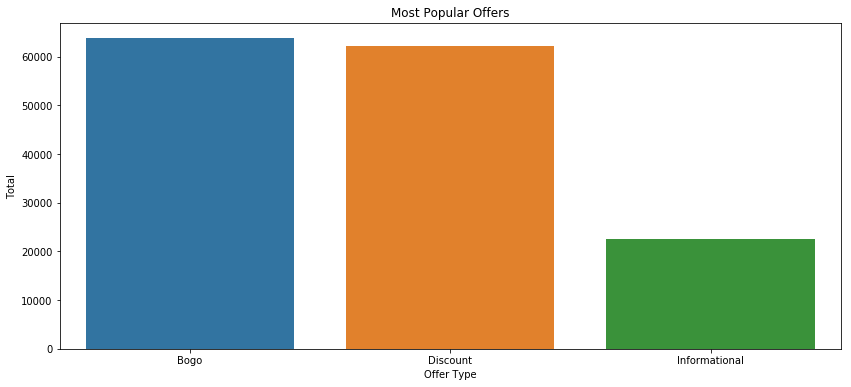

In [130]:
# Different Offer Types available and their Popularity
plt.figure(figsize=(14, 6))
offer = ['Bogo', 'Discount', 'Informational']
ax = sns.countplot(x='offer_type', data=df)
plt.ylabel('Total')
plt.xlabel('Offer Type')
ax.set_xticklabels(offer)
ax.set_title('Most Popular Offers');

Overall, Bogo is the most popular kind of Offer Type

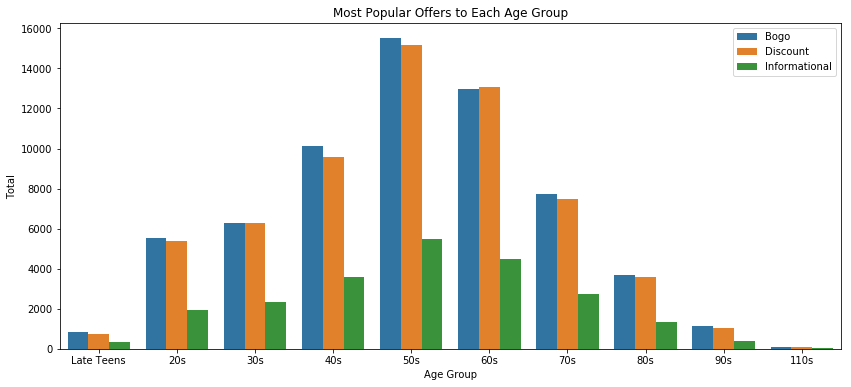

In [131]:
# Finding the most popular offers according to each age group
plt.figure(figsize=(14, 6))
g = sns.countplot(x='age_by_decade', hue="offer_type", data= df)
plt.title('Most Popular Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.legend(['Received', 'Discount', 'Informational'])
plt.show();

Looking at different age groups, we can see that Bogo is popular than any other type of offers except for the ones in theirs 30s where it is as popular as the Discount offer and the ones who are in their 60s where Discount is more popular. But Informational is the least popular of all in all age groups

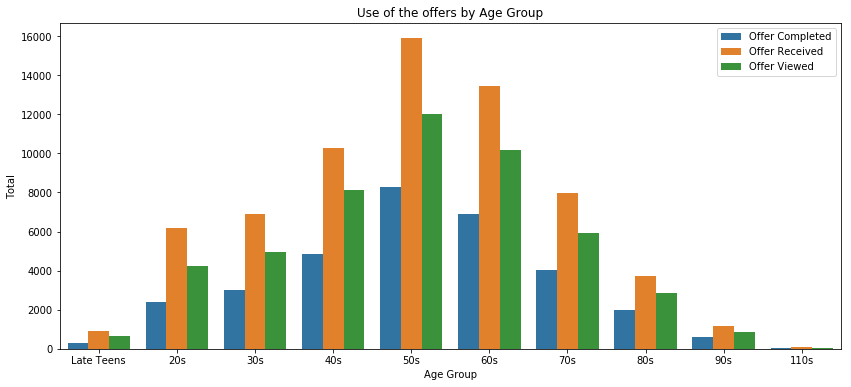

In [136]:
# Use of the offers by Each Age Group
plt.figure(figsize=(14, 6))
g = sns.countplot(x='age_by_decade', hue="event", data= df)
plt.title('Use of the offers by Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.legend(['Offer Completed', 'Offer Received', 'Offer Viewed'])
plt.show();

Looking at different age groups, we can see that mostly people either take the offer or view it. In almost every age group, almost half of the offers are being completed.

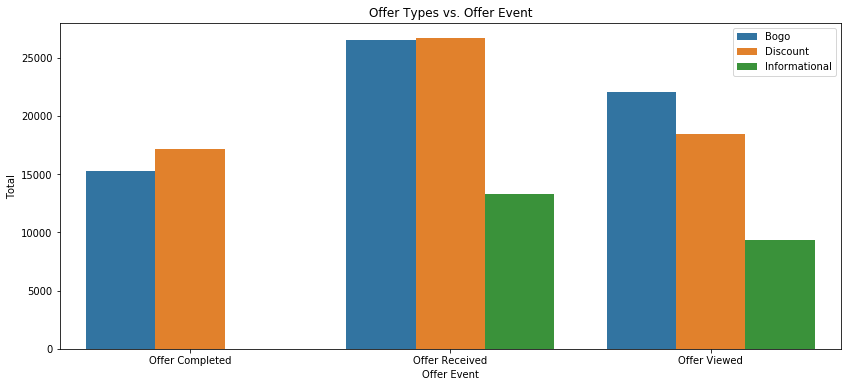

In [141]:
# Offer Types vs. Offer Events
plt.figure(figsize=(14, 6))
g = sns.countplot(x='event', hue="offer_type", data= df)
Event = ['Offer Completed', 'Offer Received', 'Offer Viewed']
plt.title('Offer Types vs. Offer Event')
plt.ylabel('Total')
plt.xlabel('Offer Event')
plt.legend(['Bogo', 'Discount', 'Informational'])
g.set_xticklabels(Event)
plt.show();

In most of the cases, the offers were received but not completed. Discount offer was the which was received by most and also completed followed by BOGO

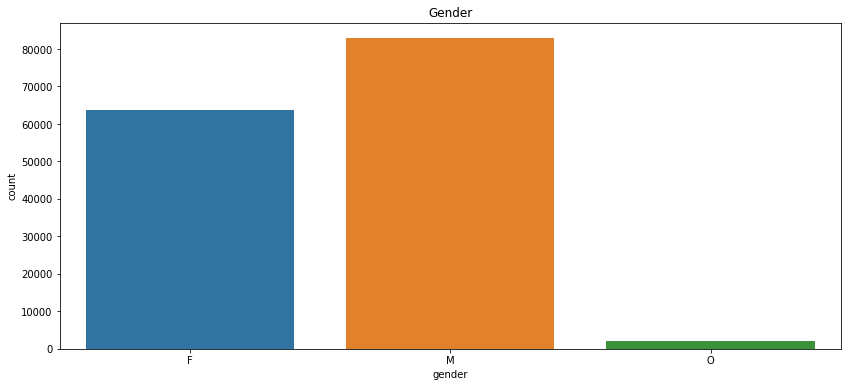

In [142]:
# Demographic by Gender
plt.figure(figsize=(14, 6))
ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender');

The app is more popular among males than any other gender

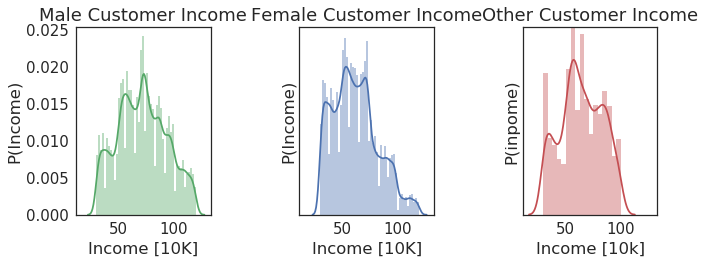

In [144]:
# Income and Gender
plt.figure(figsize=(50, 25))
male_customers = df[df['gender'] == 'F']
female_customers = df[df['gender'] == 'M']
other_customers = df[df['gender'] == 'O']

current_palette = sns.color_palette()

sns.set(font_scale=1.5)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(10, 4),
                       nrows=1,
                       ncols=3,
                       sharex=True,
                       sharey=True)

plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3,
             color=current_palette[1])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Male Customer Income')

plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3,
             color=current_palette[0])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Female Customer Income')
plt.tight_layout();

plt.sca(ax[2])
sns.distplot(other_customers['income'] * 1E-3,
            color=current_palette[2])
plt.xlabel('Income [10k]')
plt.ylabel('P(inpome)')
plt.title('Other Customer Income')
plt.tight_layout();

Looking at the income of each gender, most of the consumers from all genders have an income around 75K. With more men than women having an income more than 100K and the ones identifying as neither being non-existent in the 100K club.

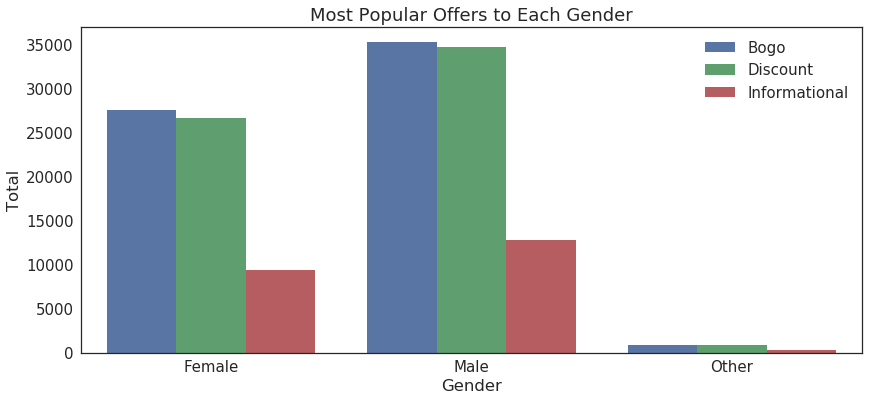

In [150]:
# Popularity of Different Offer Types among different Genders
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="offer_type", data= df)
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male', 'Other']
g.set_xticklabels(xlabels)
plt.legend(['Bogo', 'Discount', 'Informational'])
plt.show();

Even if we look by gender, Bogo is the most popular of them all

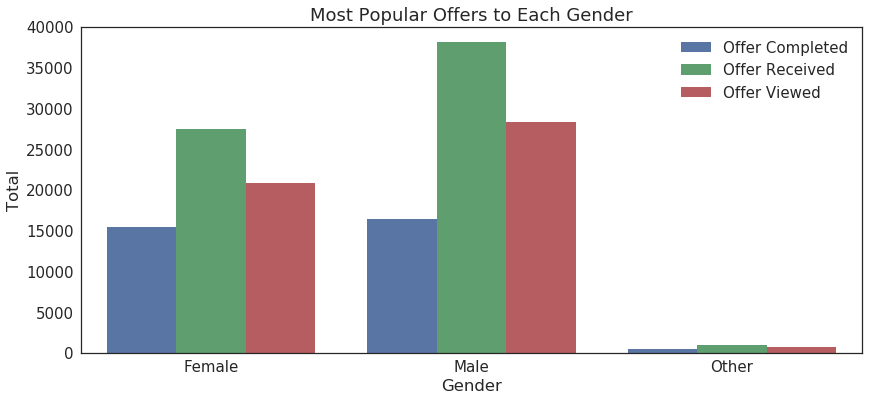

In [152]:
# Status of offers by each gender
plt.figure(figsize=(14, 6))
g = sns.countplot(x = 'gender', hue = "event", data = df)
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
g.set_xticklabels(xlabels)
plt.legend(['Offer Completed', 'Offer Received', 'Offer Viewed'])
plt.show();

Bogo might be popular only among males and females, but here we can see that only half of the people than that of the ones who receive it complete the offer.

## Data Modeling

For Data Modeling, I used Random forest, Logistic regression, SVM, Linear regression, and decision tree. And in order to check the accuracy of my model, I have used Mean Squared Error (MSE) and Mean Absolute Error (MAE). The closer these two values are to zero, the more accurate my model will be.

In order to make the model, I will need to split that data set into two; training data and test data. As the name suggests, Training Data will be used to train the model, and Test Data will be used to test it.

## Linear Regression

In [153]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [154]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [155]:
df.head()

,event,customer_id,time,offer_completed,offer_received,offer_viewed,offer_id,amount,reward_x,difficulty,duration,offer_type,reward_y,email,mobile,social,web,bogo,discount,informational,age,gender,income,became_member_tenure,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,age_bins,age_by_decade
0,2,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5,7,1,5,1,1,0,1,1,0,0,75,F,100000.0,1181,1,0,0,0,0,0,0,1,0,"(69, 79]",70s
1,3,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5,7,1,5,1,1,0,1,1,0,0,75,F,100000.0,1181,1,0,0,0,0,0,0,1,0,"(69, 79]",70s
2,1,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,5,7,1,5,1,1,0,1,1,0,0,75,F,100000.0,1181,1,0,0,0,0,0,0,1,0,"(69, 79]",70s
3,2,78afa995795e4d85b5d9ceeca43f5fef,504,0,1,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0,5,5,1,5,1,1,1,1,1,0,0,75,F,100000.0,1181,1,0,0,0,0,0,0,1,0,"(69, 79]",70s
4,1,78afa995795e4d85b5d9ceeca43f5fef,510,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,5,1,5,1,1,1,1,1,0,0,75,F,100000.0,1181,1,0,0,0,0,0,0,1,0,"(69, 79]",70s


In [179]:
X = df[['time', 'offer_completed', 'offer_received', 'offer_viewed', 'offer_type', 'age', 'gender_F', 'gender_M', 'gender_O']]
y = df['event']

In [180]:
y.dtypes

dtype('int64')

In [181]:
X.dtypes

time               int64
offer_completed    int64
offer_received     int64
offer_viewed       int64
offer_type         int64
age                int64
gender_F           int64
gender_M           int64
gender_O           int64
dtype: object

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 2)

In [183]:
regr = LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [184]:
pred = regr.predict(X_test)

In [185]:
pred

array([ 3.,  3.,  3., ...,  2.,  2.,  1.])

In [186]:
regr.score(X_train, y_train)

1.0

In [187]:
regr.predict(X_test)

array([ 3.,  3.,  3., ...,  2.,  2.,  1.])

In [188]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(X_train, y_train)
test_linear_pred = linear_model.predict(X_test)
print('MAE:', mean_absolute_error(test_linear_pred, y_test))
print('MSE:',mean_squared_error(test_linear_pred, y_test))

MAE: 6.16133153254e-13
MSE: 5.13422246156e-25


## Decision Tree

In [189]:
from sklearn.tree import DecisionTreeClassifier

In [190]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
test_tree_pred = dt.predict(X_test)
print('MAE:', mean_absolute_error(test_tree_pred, y_test))
print('MSE:',mean_squared_error(test_tree_pred, y_test))

MAE: 0.0
MSE: 0.0


## Logistic Regression

In [191]:
from sklearn.linear_model import LogisticRegression

In [192]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
test_logistic_pred = lr.predict(X_test)
print('MAE:', mean_absolute_error(test_logistic_pred, y_test))
print('MSE:',mean_squared_error(test_logistic_pred, y_test))

MAE: 0.0
MSE: 0.0


## Random Forest

In [193]:
from sklearn.ensemble import RandomForestClassifier

In [194]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
test_random_pred = rfc.predict(X_test)
print('MAE:', mean_absolute_error(test_random_pred, y_test))
print('MSE:',mean_squared_error(test_random_pred, y_test))

MAE: 0.0
MSE: 0.0


## SVM

In [195]:
from sklearn import svm

In [197]:
clf = svm.SVC()
clf.fit(X_train, y_train)
test_clf_pred = dt.predict(X_test)
print('MAE:', mean_absolute_error(test_clf_pred, y_test))
print('MSE:',mean_squared_error(test_clf_pred, y_test))

MAE: 0.0
MSE: 0.0


## Conclusion

First, I have explored each and every dataset, picked up the values that I thought were important for this project and merged it. After merging it, I visualized it to get an overall understanding on the data. Then, I moved to the Modeling Part. There, I worked on the dataset to predict the what are the chances that the person might use the offer with it's accuracy being checked with MAE and MSE.

1. The ones on their 50s are more likely to visit a Starbucks
2. Overall, Bogo is the most popular kind of Offer Type
3. Looking at different age groups, we can see that Bogo is popular than any other type of offers except for the ones in theirs 30s where it is as popular as the Discount offer and the ones who are in their 60s where Discount is more popular. But Informational is the least popular of all in all age groups
4. Looking at different age groups, we can see that mostly people either take the offer or view it. In almost every age group, almost half of the offers are being completed.
5. In most of the cases, the offers were received but not completed. Discount offer was the which was received by most and also completed followed by BOGO
6. Looking at the income of each gender, most of the consumers from all genders have an income around 75K. With more men than women having an income more than 100K and the ones identifying as neither being non-existent in the 100K club.
7. Even if we look by gender, Bogo is the most popular of them all
8. Bogo might be popular only among males and females, but here we can see that only half of the people than that of the ones who receive it complete the offer.
9. In Data Modeling, SVM, Random Forest, Logistic Regression and Decision Tree had the most accurate prediction with the Mean Squared Error and Mean Absolute Error being 0.0 which means that there is no error.
10. When it came to prediction, I believe that I have done a pretty good job as all the predictions have been closer to zero. Though I believe that it could've gotten better but I don't have much experience in Machine Learning and Model Prediction.

## Improvements

I believe that the results that I have are near perfect as we have seen that the error in most of the models were 0.0. Hpwever, there is always a room for imporvement. Maybe if there was a lack of Null values would have been better. For that there needds to be an improvement in Data Collection. We can also improve this project by taking up another problem statement, we can make a model that predicts which demographic groups will make purchases even if they don't receive an offer.